First, I get the data.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras as kr
from sklearn import model_selection
import matplotlib.pyplot as plt
import math
import cv2
import random

ratings = pd.read_csv("http://files.grouplens.org/datasets/movielens/ml-100k/u1.base",sep='\t',header=None, names=["userId", "movieId", "rating", "timestamp"])

items = pd.read_csv("http://files.grouplens.org/datasets/movielens/ml-100k/u.item",
                    sep='|',
                    header=None,
                    encoding="latin1",
                    names=["movieId", "title", "date released", "video_release_date", "link", "Genere_1", "Genere_2", "Genere_3", "Genere_4", "Genere_5", "Genre_6", "Genere_7", "Genere_8", "Genre_9", "Genere_10", "Genere_11", "Genere_12", "Genere_13", "Genere_14", "Genre_15", "Genere_16", "Genere_17", "Genre_18", "Genre_19"])


In [2]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [3]:
items.head()

,movieId,title,date released,video_release_date,link,Genere_1,Genere_2,Genere_3,Genere_4,Genere_5,...,Genere_10,Genere_11,Genere_12,Genere_13,Genere_14,Genre_15,Genere_16,Genere_17,Genre_18,Genre_19
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
items[items.title == 'unknown']

,movieId,title,date released,video_release_date,link,Genere_1,Genere_2,Genere_3,Genere_4,Genere_5,...,Genere_10,Genere_11,Genere_12,Genere_13,Genere_14,Genre_15,Genere_16,Genere_17,Genre_18,Genre_19
266,267,unknown,NaN,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I filter away unknown, as the Colab we were given suggested.

In [6]:
filtered_items = items[items.title != 'unknown']
filtered_ratings = ratings[ratings.movieId != 267]
filtered_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [7]:
ratings.info()
filtered_ratings.info()
print()
items.info()
filtered_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   userId     80000 non-null  int64
 1   movieId    80000 non-null  int64
 2   rating     80000 non-null  int64
 3   timestamp  80000 non-null  int64
dtypes: int64(4)
memory usage: 2.4 MB
<class 'pandas.core.frame.DataFrame'>
Index: 79997 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   userId     79997 non-null  int64
 1   movieId    79997 non-null  int64
 2   rating     79997 non-null  int64
 3   timestamp  79997 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movieId             1682 non-null   int64  
 1

In the previous stage, I noticed that two movies had null links, so I checked which ones. I decided that it didn't matter.

In [8]:
filtered_items[filtered_items.link.isnull()]

,movieId,title,date released,video_release_date,link,Genere_1,Genere_2,Genere_3,Genere_4,Genere_5,...,Genere_10,Genere_11,Genere_12,Genere_13,Genere_14,Genre_15,Genere_16,Genere_17,Genre_18,Genre_19
1357,1358,The Deadly Cure (1996),16-Sep-1996,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1358,1359,Boys in Venice (1996),24-Sep-1996,NaN,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As you can see, 4 is apparently the most common rating.

array([[<Axes: title={'center': 'rating'}>]], dtype=object)

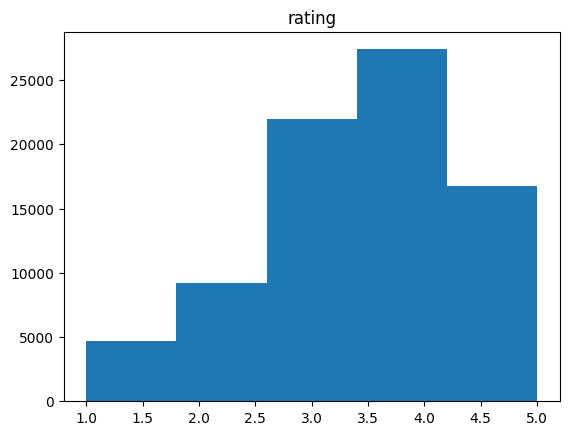

In [9]:
ratings.hist(column='rating', grid=False, bins=5)

Since the rating's standard deviation is 1.1186, any model that fails to actually learn anything will end up around there, such as my baseline model.

In [10]:
ratings.describe()

,userId,movieId,rating,timestamp
count,80000.00000,80000.000000,80000.000000,8.000000e+04
mean,525.16570,425.705200,3.528350,8.835645e+08
std,255.94956,331.383936,1.118565,5.318611e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,334.00000,175.000000,3.000000,8.794556e+08
50%,535.00000,321.000000,4.000000,8.828441e+08
75%,744.00000,631.000000,4.000000,8.882676e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


Some of these values and movies are really rare. And this isn't even counting a few movies that don't show up at all. I decided to ignore it, though, figuring that if these movies are really so rare, my performance wouldn't be penalized much for not dealing with them. This is a case where a Content-Based Filtering model would probably do better.

In [11]:
print(ratings['userId'].value_counts())
print(ratings['movieId'].value_counts())

userId
655    685
405    582
450    494
537    490
416    417
      ... 
36       9
93       9
258      8
228      7
310      4
Name: count, Length: 943, dtype: int64
movieId
50      484
181     422
258     402
100     395
294     394
       ... 
1360      1
1593      1
1329      1
1550      1
1682      1
Name: count, Length: 1650, dtype: int64


In [12]:
def plot_history(history):
    # plot the rmse
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


X_base = filtered_ratings[['userId', 'movieId']].to_numpy()
Y_base = filtered_ratings['rating'].to_numpy()
print(X_base.shape)
print(X_base[:5, :])
X_base_train, X_base_val, Y_base_train, Y_base_val = model_selection.train_test_split(X_base, Y_base, test_size=0.2, shuffle=True, stratify=X_base[:, 0])
# If I did this right, we should have the users' stuff in X and Y

(79997, 2)
[[1 1]
 [1 2]
 [1 3]
 [1 4]
 [1 5]]


This is my baseline model, a simple linear regression, but since it ends up around standard deviation, something is clearly going wrong here.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
2000/2000 [==============================] - 5s 2ms/step - loss: 370112.6562 - root_mean_squared_error: 608.3688 - val_loss: 285432.8750 - val_root_mean_squared_error: 534.2592
Epoch 2/300
2000/2000 [==============================] - 4s 2ms/step - loss: 224213.7344 - root_mean_squared_error: 473.5121 - val_loss: 177298.7344 - val_root_mean_squared_error: 421.0686
Epoch 3/300
2000/2000 [==============================] - 4s 2ms/step - loss: 143953.7500 - root_mean_squared_error: 379.4124 - val_loss: 119354.5625 - val_root_mean_squared_e

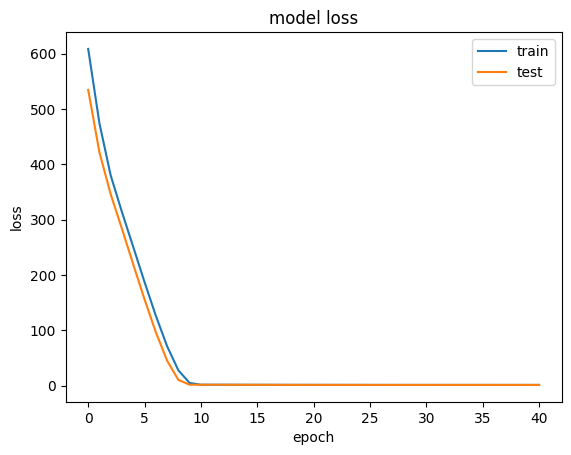

In [49]:
# Okay, what I need to do first is figure out how I would even test a model
# Then, I would build a baseline model that predicts the thing with the highest mean rating not watched by this person
# Okay, I'm going to have to do things I'm not used to doing
# So, first, what exactly is my model?
# I think what I'm really getting hung up on is, what exactly are we testing on?
# Like, how do you give test data? How do you check performance? What does that even mean?
# It looks like you give data with half the reviews missing, and see if it recommends the right ones?
# What is the output even supposed to look like?
# Argh

# Okay, I have a better idea of what I'm doing having spammed the chat
# So, this baseline model isn't actually predicting anything, it's just getting a feel for the users
# But it can't actually solve the cold-start problem and predict users it doesn't have data on
# That's where matrix factorization comes in
# But I should start by making something simple, but with no real validation data
# Or, maybe I could use validation data, but stratified by user

BASE_LEARNING_RATE = 0.0001
BASE_NUM_EPOCHS = 300

# A single linear layer with a single output is effectively a linear regression
baseline_model = kr.models.Sequential([
    kr.Input(shape=X_base_train[0].shape),
    kr.layers.Dense(1, activation='linear')
])

baseline_model.compile(optimizer=kr.optimizers.Adam(learning_rate=BASE_LEARNING_RATE), loss='mean_squared_error',
              metrics=[kr.metrics.RootMeanSquaredError()])
baseline_model.summary()
baseline_history = baseline_model.fit(X_base_train, Y_base_train, epochs=BASE_NUM_EPOCHS, validation_data=(X_base_val, Y_base_val),
          callbacks=[kr.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=2, start_from_epoch=5)])

# plot the rmse
plot_history(baseline_history)


DO NOT RUN THIS. In order to get later models to work, I removed movies that didn't have a single user watching them and moved all the IDs up one, so that IDs would all be present. Unfortunately, it looks like this caused problems that prevented my model from learning. I'm not sure how this failed, only that running the second code block instead causes RMSE to drop from 1.06 to 0.92.

In [13]:
num_users = len(filtered_ratings['userId'].value_counts())
num_movies = len(filtered_ratings['movieId'].value_counts())
num_dif = 0
missing_movies = []
for user, val in zip(np.sort(filtered_ratings['movieId'].unique()), range(num_movies)):
    while user != val + num_dif:
        print(f'Movie is {user} but val is {val + num_dif}')
        missing_movies.append(val + num_dif)
        num_dif += 1 # after, because +1 is what movie is


print(missing_movies)


def fix_users_and_movies(X_base):
    num_dif = 0
    # Okay, let's think algorithmically (haven't had to do that in a while)
    # So, let's say that each time I'm up here, I check if the current index is our current location in the array
    # If it is, I will increase our current sum
    # That sum is also the index of the next element
    X_simple = []
    for row in X_base[X_base[:, 1].argsort()]:
        # a[a[:, 1].argsort()]
        while num_dif < len(missing_movies) and row[1] > missing_movies[num_dif]:
            num_dif += 1
            # print(f'{num_dif} at {row}')
        # print(f'Original: {row}')
        # print(np.subtract(row, np.array([1, num_dif])))
        # if 0 < num_dif <= 1:
          #   print(X_simple)
        if len(X_simple) == 0:  # Getting the right shape for append to work right was too annoying
            X_simple = np.subtract(row, np.array([1, num_dif])).reshape((1, 2))
        else:
            X_simple = np.append(X_simple, np.subtract(row, np.array([1, num_dif])).reshape((1, 2)), axis=0)
            # Subtract 1, because users are missing index 0
    return X_simple


# Let's start by changing filtered_ratings and the like to have everything after 267 one lower
X_simple_pre = fix_users_and_movies(filtered_ratings[['userId', 'movieId']].to_numpy())

print(X_simple_pre.shape)
print(X_simple_pre[0:5, :])
print(X_base.shape)

X_simple_train, X_simple_val, Y_simple_train, Y_simple_val = model_selection.train_test_split(X_simple_pre, Y_base, test_size=0.2, shuffle=True) #, stratify=X_base[:, 0])

Movie is 1 but val is 0
Movie is 268 but val is 267
Movie is 600 but val is 599
Movie is 712 but val is 711
Movie is 815 but val is 814
Movie is 831 but val is 830
Movie is 853 but val is 852
Movie is 858 but val is 857
Movie is 1157 but val is 1156
Movie is 1237 but val is 1236
Movie is 1311 but val is 1309
Movie is 1311 but val is 1310
Movie is 1321 but val is 1320
Movie is 1344 but val is 1343
Movie is 1349 but val is 1348
Movie is 1365 but val is 1364
Movie is 1374 but val is 1373
Movie is 1459 but val is 1457
Movie is 1459 but val is 1458
Movie is 1494 but val is 1492
Movie is 1494 but val is 1493
Movie is 1499 but val is 1498
Movie is 1506 but val is 1505
Movie is 1521 but val is 1520
Movie is 1534 but val is 1533
Movie is 1537 but val is 1536
Movie is 1544 but val is 1543
Movie is 1558 but val is 1557
Movie is 1564 but val is 1561
Movie is 1564 but val is 1562
Movie is 1564 but val is 1563
Movie is 1566 but val is 1565
Movie is 1583 but val is 1582
Movie is 1587 but val is 1586


This is my simple model. It works pretty well. Given my results, I'm assuming that either Netflix's challenge was more sophisticated then what we are doing here (maybe including cold start problems) in a way that increases RMSE or I did something wrong. But everything in my model looks correct.

In [15]:
# What if we just leave movies as they are?
num_users = max(filtered_ratings['userId']) + 1 # 0 is a dummy value
num_movies = max(filtered_ratings['movieId']) + 1
X_simple_train, X_simple_val, Y_simple_train, Y_simple_val = model_selection.train_test_split(X_base, Y_base, test_size=0.2, shuffle=True)

944
1683
global average rating: 3.5299467162523244


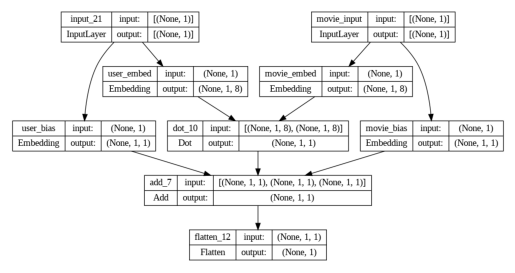

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embed (Embedding)      (None, 1, 8)                 7552      ['input_21[0][0]']            
                                                                                                  
 movie_embed (Embedding)     (None, 1, 8)                 13464     ['movie_input[0][0]']         
                                                                                           

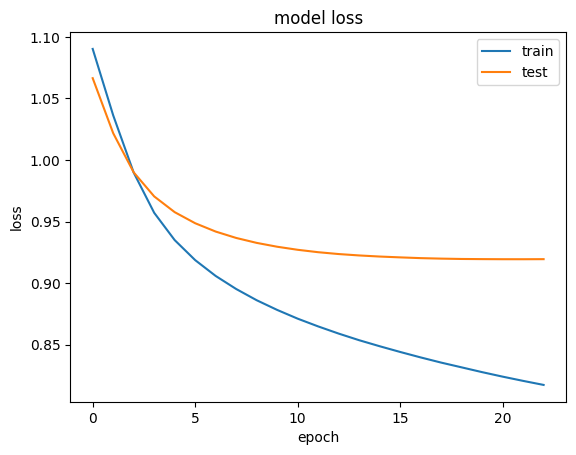

In [38]:
MEAN_RATING = Y_simple_train.mean()
SIMPLE_LEARNING_RATE = 0.0005
SIMPLE_NUM_EPOCHS = 300
SIMPLE_EMBED_SIZE = 8
SIMPLE_REG_PENALTY = 1e-4

print(num_users)
print(num_movies)

print(f"global average rating: {MEAN_RATING}")

# because there are multiple inputs that go through different layers, I had to use the keras functional model
user_input = kr.layers.Input(shape=(1,))
movie_input = kr.layers.Input(shape=(1,), name='movie_input')

user_embedding = kr.layers.Embedding(num_users, SIMPLE_EMBED_SIZE, embeddings_regularizer=kr.regularizers.l2(SIMPLE_REG_PENALTY), name='user_embed')(user_input)
movie_embedding = kr.layers.Embedding(num_movies, SIMPLE_EMBED_SIZE, embeddings_regularizer=kr.regularizers.l2(SIMPLE_REG_PENALTY), name='movie_embed')(movie_input)

user_bias = kr.layers.Embedding(num_users, 1, embeddings_regularizer=kr.regularizers.l2(SIMPLE_REG_PENALTY), name='user_bias')(user_input)
movie_bias = kr.layers.Embedding(num_movies, 1, embeddings_regularizer=kr.regularizers.l2(SIMPLE_REG_PENALTY), name='movie_bias')(movie_input)

joint_output = kr.layers.Dot(axes=2)([user_embedding, movie_embedding])
joint_output = kr.layers.Add()([joint_output, user_bias, movie_bias])
joint_output = kr.layers.Flatten()(joint_output)  # numpy is so clunky...

simple_model = kr.Model(inputs=[user_input, movie_input], outputs=joint_output)

kr.utils.plot_model(simple_model, "simple_model.png", show_shapes=True)
simple_image = cv2.imread("simple_model.png", cv2.IMREAD_COLOR)
plt.imshow(simple_image)
plt.axis("off")
plt.show()

simple_model.compile(optimizer = kr.optimizers.Adam(SIMPLE_LEARNING_RATE), loss='mean_squared_error', metrics=[kr.metrics.RootMeanSquaredError()])

simple_model.summary()

simple_history = simple_model.fit(x=[X_simple_train[:, 0], X_simple_train[:, 1]], y=Y_simple_train - MEAN_RATING, epochs=SIMPLE_NUM_EPOCHS, validation_data = ([X_simple_val[:, 0], X_simple_val[:, 1]], Y_simple_val - MEAN_RATING),
                                  callbacks=[kr.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=0, start_from_epoch=2)])

# plot the rmse
plot_history(simple_history)

I decided to try using my model for a cold start user, who just joined the platform. So, I invented a user, gave them some movies, and tried to generate an embedding for them. I'm getting perfect near perfect RMSE, but that might just be that with such a small watchlist, the embedding can hold all of the information.

In [18]:
cold_user = np.array((1, 4, 55, 66, 501, 604, 1000))
cold_user_ratings = np.array((1, 2, 5, 5, 4, 3, 5)) - MEAN_RATING

cold_start_embedder = kr.Model(inputs=simple_model.get_layer('movie_input').input, outputs=simple_model.get_layer('movie_embed').output)
user_movie_embeddings = cold_start_embedder.predict(x = cold_user)
print(user_movie_embeddings.shape)
user_movie_embeddings = user_movie_embeddings.reshape(len(cold_user),SIMPLE_EMBED_SIZE)

user_embedding, residuals, rank, s = np.linalg.lstsq(user_movie_embeddings, cold_user_ratings, rcond=-1)
# solve a x c = b, returning c
user_embedding = user_embedding.reshape(SIMPLE_EMBED_SIZE, 1)
print(user_embedding)

movie_embeddings = np.array(simple_model.get_layer('movie_embed').weights).reshape((num_movies, SIMPLE_EMBED_SIZE))

print(user_embedding.shape)
print(movie_embeddings.shape)
cold_ratings = np.dot(movie_embeddings, user_embedding)

print(cold_ratings.shape)

print(cold_ratings)
for movie in cold_user:
    print(movie_embeddings[movie])

for movie, rating in zip(cold_user, cold_user_ratings):
    print(f'For movie {movie}, predicted {cold_ratings[movie] + MEAN_RATING}, was actually {rating + MEAN_RATING}')

print(cold_ratings[[cold_user]])
# This is the RMSE
print(np.mean((cold_user_ratings - cold_ratings[[cold_user]].reshape(len(cold_user))) ** 2) ** 0.5)


1/1 [==============================] - 0s 137ms/step
(7, 1, 8)
[[-21.18469951]
 [ 20.13574506]
 [  9.19453068]
 [-17.01945691]
 [ -0.83096087]
 [-23.24881695]
 [ -9.50156894]
 [-17.2450954 ]]
(8, 1)
(1683, 8)
(1683, 1)
[[-6.70298798e-31]
 [-2.52994672e+00]
 [-1.44898847e+00]
 ...
 [ 2.23531521e-30]
 [-1.75228601e-30]
 [-4.53028108e-01]]
[ 0.48943684  0.26115814 -0.23135912 -0.02868701  0.14004621 -0.47169876
  0.2433698   0.25042814]
[ 0.23058225  0.1822673  -0.36621523  0.17238027  0.13300185 -0.23190866
 -0.40916786  0.18457668]
[-0.10154822  0.23482169 -0.21493     0.29077512 -0.24075729 -0.21707936
 -0.30790177  0.38602036]
[ 0.44490796  0.31201193 -0.35544407 -0.3321936   0.5646854  -0.12762389
  0.43983498 -0.22663477]
[ 0.12102182  0.3270582  -0.4998948   0.15583228 -0.10347418 -0.16066524
  0.24647222 -0.12858123]
[ 0.04490859  0.12143118  0.0181682  -0.04269444 -0.15260984  0.16819355
 -0.04777468 -0.0239019 ]
[ 0.01353474  0.01416723  0.00331963  0.01183812 -0.06742878 -0.038

Preprocessing for the hybrid model.

In [50]:
print(filtered_items.columns)

fixed_items = {id:filtered_items[['Genere_1', 'Genere_2', 'Genere_3', 'Genere_4', 'Genere_5', 'Genre_6', 'Genere_7', 'Genere_8', 'Genre_9','Genere_10','Genere_11','Genere_12','Genere_13','Genere_14','Genre_15','Genere_16','Genere_17','Genre_18','Genre_19']].loc[filtered_items['movieId'] == id].values
               for id in filtered_items['movieId']}
# I really should have editted the code given, since it spells genre two different ways

print(fixed_items[5])

X_genres_movies_train = np.array([fixed_items[movie] for user, movie in X_simple_train]).reshape(len(X_simple_train), 19)
X_genres_movies_val = np.array([fixed_items[movie] for user, movie in X_simple_val]).reshape(len(X_simple_val), 19)

Index(['movieId', 'title', 'date released', 'video_release_date', 'link',
       'Genere_1', 'Genere_2', 'Genere_3', 'Genere_4', 'Genere_5', 'Genre_6',
       'Genere_7', 'Genere_8', 'Genre_9', 'Genere_10', 'Genere_11',
       'Genere_12', 'Genere_13', 'Genere_14', 'Genre_15', 'Genere_16',
       'Genere_17', 'Genre_18', 'Genre_19'],
      dtype='object')
[[0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0]]


For the hybrid model, I use an ensemble where after getting the result of the simple model, I run it through a neural network that also sees the genres of that movie so that it can adjust things accordingly.

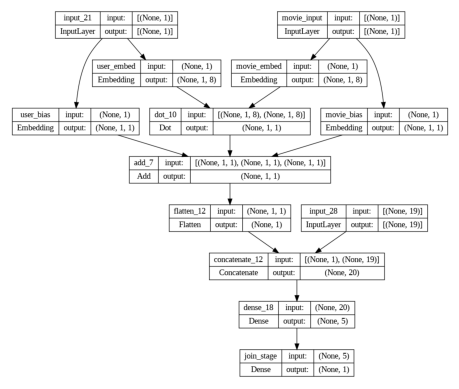

Epoch 1/300
2000/2000 [==============================] - 10s 4ms/step - loss: 1.4716 - root_mean_squared_error: 1.1827 - val_loss: 1.1897 - val_root_mean_squared_error: 1.0577
Epoch 2/300
2000/2000 [==============================] - 7s 3ms/step - loss: 0.9460 - root_mean_squared_error: 0.9348 - val_loss: 0.9562 - val_root_mean_squared_error: 0.9396
Epoch 3/300
2000/2000 [==============================] - 9s 4ms/step - loss: 0.7656 - root_mean_squared_error: 0.8316 - val_loss: 0.9358 - val_root_mean_squared_error: 0.9281
Epoch 4/300
2000/2000 [==============================] - 7s 3ms/step - loss: 0.7376 - root_mean_squared_error: 0.8141 - val_loss: 0.9400 - val_root_mean_squared_error: 0.9301
Epoch 5/300
2000/2000 [==============================] - 6s 3ms/step - loss: 0.7314 - root_mean_squared_error: 0.8101 - val_loss: 0.9394 - val_root_mean_squared_error: 0.9295


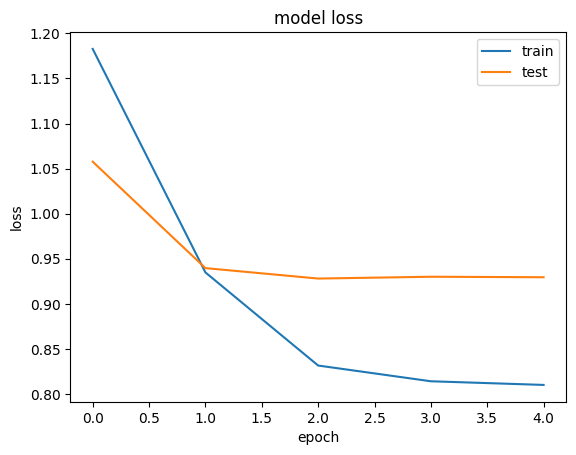

[<tf.Variable 'join_stage/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[-1.0481508],
       [-0.3836436],
       [ 0.8463095],
       [ 0.9724232],
       [ 0.7901162]], dtype=float32)>, <tf.Variable 'join_stage/bias:0' shape=(1,) dtype=float32, numpy=array([-0.02593386], dtype=float32)>]


In [51]:
NUM_FEATURES = 19
HIDDEN_SIZE = 10
HYBRID_LEARNING_RATE = 0.0001
HYBRID_REG_PENALTY = 1e-4

genre_input_2 = kr.Input(shape=(NUM_FEATURES))

X_genres_train = np.array([fixed_items[movie] for user, movie in X_simple_train]).reshape(len(X_simple_train), NUM_FEATURES)
X_genres_val = np.array([fixed_items[movie] for user, movie in X_simple_val]).reshape(len(X_simple_val), NUM_FEATURES)

# joint_output is the output for the simple model
hybrid_stage = kr.layers.Concatenate()([joint_output, genre_input_2])
hybrid_stage = kr.layers.Dense(5, activation='linear', activity_regularizer=kr.regularizers.l2(HYBRID_REG_PENALTY))(hybrid_stage)
hybrid_stage = kr.layers.Dense(1, activation='linear', name='join_stage', activity_regularizer=kr.regularizers.l2(HYBRID_REG_PENALTY))(hybrid_stage)

hybrid_model = kr.Model(inputs=[user_input, movie_input, genre_input_2
                                ], outputs=hybrid_stage)

kr.utils.plot_model(hybrid_model, "hybrid_model.png", show_shapes=True)
hybrid_image = cv2.imread("hybrid_model.png", cv2.IMREAD_COLOR)
plt.imshow(hybrid_image)
plt.axis("off")
plt.show()

hybrid_model.compile(optimizer = kr.optimizers.Adam(HYBRID_LEARNING_RATE), loss='mean_squared_error', metrics=[kr.metrics.RootMeanSquaredError()])
hybrid_history = hybrid_model.fit(x=[X_simple_train[:, 0], X_simple_train[:, 1], X_genres_movies_train
                                     ], y=Y_simple_train - MEAN_RATING, epochs=SIMPLE_NUM_EPOCHS,
                 validation_data = ([X_simple_val[:, 0], X_simple_val[:, 1], X_genres_movies_val
                                     ], Y_simple_val - MEAN_RATING),
                                  callbacks=[kr.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=2, start_from_epoch=2)])

# plot the rmse
plot_history(hybrid_history)
print(hybrid_model.get_layer('join_stage').weights)

After all is done, we test everything. The simple model gets an RMSE of 0.87, while hybrid gets 0.83. See my writeup for my speculation why this is so much better than validation RMSE.

In [53]:
test_ratings_df = pd.read_csv("http://files.grouplens.org/datasets/movielens/ml-100k/u1.test",sep='\t',header=None, names=["userId", "movieId", "rating", "timestamp"])
X_test = filtered_ratings[['userId', 'movieId']].to_numpy()
Y_test = filtered_ratings['rating'].to_numpy()

X_genres_test = np.array([fixed_items[movie] for user, movie in X_test]).reshape(len(X_test), NUM_FEATURES)

simple_model.evaluate([X_test[:, 0], X_test[:, 1]], Y_test - MEAN_RATING)
hybrid_model.evaluate([X_test[:, 0], X_test[:, 1], X_genres_test], Y_test - MEAN_RATING)


2500/2500 [==============================] - 4s 2ms/step - loss: 0.7679 - root_mean_squared_error: 0.8322


[0.7678607106208801, 0.8321638107299805]